In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import pandas as pd
from sktime.classification.hybrid import HIVECOTEV2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier

# Different voting methods
It was also experimented with implementing differen voting methods. This was not further pursued.

### Choquete

In [ ]:
#from choquet_classifier_glenscalai.choquet_classifier import ChoquetClassifier

#clf = ChoquetClassifier()
#clf.fit(X_train, y_train)

C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#clf.score(X_test, y_test)

# Final Ensemble results

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import pandas as pd
from sktime.classification.hybrid import HIVECOTEV2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv

In [4]:
#1:2 ratio
#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])

#filtered users
fu = pd.read_csv('filtered_user_lists.csv')
fu_tbt = pd.read_csv('filtered_user_lists_only_tpd_tbt.csv')
fu_maxtime = pd.read_csv('filtered_user_lists_only_tpd_maxtime.csv')
#tpd pairs
tpd_pairs = pd.read_csv('pairs_tpd_users.csv')
filtered_users = pd.concat([fu, fu_tbt, fu_maxtime], ignore_index=True)
#-------------------------------------------------------------------
j = 948
current = filtered_users.iloc[j]
print(current)
current_user_list = eval(current.user_list)

#get distribution of current filtered list
avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day']==avg].count()/len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

#downsample current user list based on distribution
current_samples = pd.DataFrame(columns=['user id', 'tweets per day'])
for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
    frac = float(dist_df.loc[dist_df['tweets per day']==tpd]['percentage'].iloc[0])
    if int(n_depression*frac)<len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression*frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False) #sort percentages here

#fill up remaining spots with random users from rs cohort not yet present in sampled users starting with most occuring tpd class in filtered user list (all tpd not already in sampled list)
needed_tpd = []
counter = n_depression-len(current_samples['user id'].unique())
if counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop>0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1
print(counter)
print(len(current_samples['user id'].unique()))
#if still space left, fill again, this time not caring if tpd is already in final list with samples from all users in rs cohort, with disregard to filtered users

current_user_list = list(set(st.user_id.unique()).symmetric_difference(set(current_samples['user id'].unique())))

avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day']==avg].count()/len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
    frac = float(dist_df.loc[dist_df['tweets per day']==tpd]['percentage'].iloc[0])
    if int(n_depression*frac)<len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression*frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False) #sort percentages here

needed_tpd = []
counter = n_depression-len(current_samples['user id'].unique())
while counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop>0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1

print(len(current_samples['user id'].unique()))
#assamble data
data = {}
labels = []
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(1)

for user in current_samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(0)

df_data = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
df_labels = pd.DataFrame(labels)
#----------------------------------------------------
from sklearn.model_selection import train_test_split

df_data = df_data.transpose()
df_data.index = range(0, len(df_data.index))
df_data.sort_index()
df_data = df_data.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2)
#---------------------------------------------------------------------------------

603
Unnamed: 0                                                       108
min_tpd                                                           10
max_days_bt                                                        1
min_days_active                                                   30
user_list          ['uR0011', 'uR0014', 'uR0015', 'uR0022', 'uR00...
Name: 948, dtype: object
16
587
1156


In [6]:
from sklearn.metrics import PrecisionRecallDisplay
scoring = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc', 'average_precision']

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct


dpk = DotProduct()

clf1 = SVC(C = 0.2,gamma='auto', kernel='linear', random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='auto', leaf_size=16, metric='cosine')
clf3 = DecisionTreeClassifier(criterion='gini', splitter='random', random_state=42)
clf4 = GaussianProcessClassifier(kernel = dpk, n_restarts_optimizer = 4, max_iter_predict =50, random_state=42)
clf5 = GaussianNB(var_smoothing= 0.0000000001)
clf6 = QuadraticDiscriminantAnalysis(reg_param=0.0000)

eclf = VotingClassifier(estimators=[('svm', clf1), ('knn', clf2), ('dtc', clf3), ('gpc', clf4), ('gnb', clf5), ('qda', clf6)], voting='hard')

classifier_pipe = make_pipeline(StandardScaler(), eclf)


C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parame

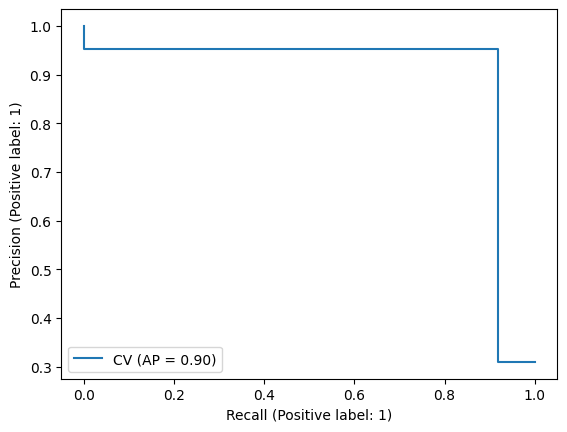

In [7]:
eclf_scores = cross_validate(classifier_pipe, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

with open('.\cv_pr\cv_eclf_scores_final.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = eclf_scores.keys())
    writer.writeheader()
    writer.writerow(eclf_scores)

start = time.perf_counter()
classifier_pipe.fit(X_train, y_train)
end = time.perf_counter()
train_time = end - start

score = classifier_pipe.score(X_test, y_test.to_numpy()[:, 0])

start = time.perf_counter()
y_pred = classifier_pipe.predict(X_test)
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='Custom Voting Classifier')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name='CV')
plt.savefig('.\cv_new_figs\cv_pr.png')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test.to_numpy()[:,0], y_pred, average='binary', pos_label=1)
print('Voting Classifier 1:2')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)
#1:2 ratio

# 1:4 ratio

In [8]:
#1:4 ratio
#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())*2
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])

#filtered users
fu = pd.read_csv('filtered_user_lists.csv')
fu_tbt = pd.read_csv('filtered_user_lists_only_tpd_tbt.csv')
fu_maxtime = pd.read_csv('filtered_user_lists_only_tpd_maxtime.csv')
#tpd pairs
tpd_pairs = pd.read_csv('pairs_tpd_users.csv')
filtered_users = pd.concat([fu, fu_tbt, fu_maxtime], ignore_index=True)
#-------------------------------------------------------------------
j = 948
current = filtered_users.iloc[j]
print(current)
current_user_list = eval(current.user_list)

#get distribution of current filtered list
avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day']==avg].count()/len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

#downsample current user list based on distribution
current_samples = pd.DataFrame(columns=['user id', 'tweets per day'])
for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
    frac = float(dist_df.loc[dist_df['tweets per day']==tpd]['percentage'].iloc[0])
    if int(n_depression*frac)<len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression*frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False) #sort percentages here

#fill up remaining spots with random users from rs cohort not yet present in sampled users starting with most occuring tpd class in filtered user list (all tpd not already in sampled list)
needed_tpd = []
counter = n_depression-len(current_samples['user id'].unique())
if counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop>0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1
print(counter)
print(len(current_samples['user id'].unique()))
#if still space left, fill again, this time not caring if tpd is already in final list with samples from all users in rs cohort, with disregard to filtered users

current_user_list = list(set(st.user_id.unique()).symmetric_difference(set(current_samples['user id'].unique())))

avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day']==avg].count()/len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
    frac = float(dist_df.loc[dist_df['tweets per day']==tpd]['percentage'].iloc[0])
    if int(n_depression*frac)<len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression*frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False) #sort percentages here

needed_tpd = []
counter = n_depression-len(current_samples['user id'].unique())
while counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day']==tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop>0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1

print(len(current_samples['user id'].unique()))
#assamble data
data = {}
labels = []
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(1)

for user in current_samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(0)

df_data = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
df_labels = pd.DataFrame(labels)
#----------------------------------------------------
from sklearn.model_selection import train_test_split

df_data = df_data.transpose()
df_data.index = range(0, len(df_data.index))
df_data.sort_index()
df_data = df_data.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2)
#---------------------------------------------------------------------------------

1206
Unnamed: 0                                                       108
min_tpd                                                           10
max_days_bt                                                        1
min_days_active                                                   30
user_list          ['uR0011', 'uR0014', 'uR0015', 'uR0022', 'uR00...
Name: 948, dtype: object
96
1110
2273


In [9]:
from sklearn.metrics import PrecisionRecallDisplay
scoring = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc', 'average_precision']

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct


dpk = DotProduct()

clf1 = SVC(C = 4.8,gamma='auto', kernel='linear', random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='brute', leaf_size=27, metric='cosine')
clf3 = DecisionTreeClassifier(criterion='log_loss', splitter='best', random_state=42)
clf4 = GaussianProcessClassifier(kernel = dpk, n_restarts_optimizer = 4, max_iter_predict =140, random_state=42)
clf5 = GaussianNB(var_smoothing=0.0000000001)
clf6 = QuadraticDiscriminantAnalysis(reg_param=0.0000)

eclf = VotingClassifier(estimators=[('svm', clf1), ('knn', clf2), ('dtc', clf3), ('gpc', clf4), ('gnb', clf5), ('qda', clf6)], voting='hard')

classifier_pipe = make_pipeline(StandardScaler(), eclf)

C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parame

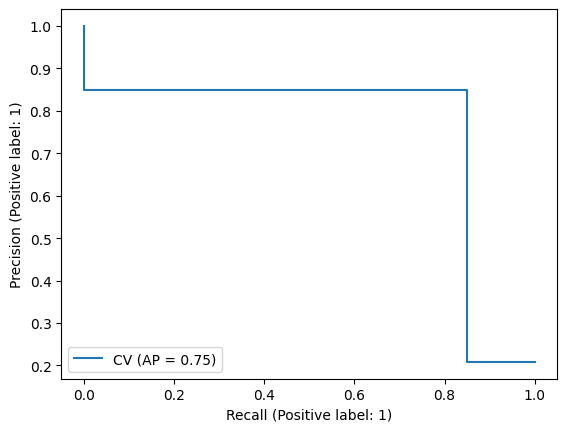

In [11]:
eclf_scores = cross_validate(classifier_pipe, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

with open('.\cv_pr\cv_eclf_scores_double_final.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = eclf_scores.keys())
    writer.writeheader()
    writer.writerow(eclf_scores)

start = time.perf_counter()
classifier_pipe.fit(X_train, y_train)
end = time.perf_counter()
train_time = end - start

score = classifier_pipe.score(X_test, y_test.to_numpy()[:, 0])

start = time.perf_counter()
y_pred = classifier_pipe.predict(X_test)
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='Custom Voting Classifier')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name='CV')
plt.savefig('.\cv_new_figs\cv_double_pr.png')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test.to_numpy()[:,0], y_pred, average='binary', pos_label=1)
print('Voting Classifier 1:4')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)
#1:4 ratio

# full

In [12]:
# no downsampling
#depression tweets
from tensorboard.plugins.hparams import api as hp
import uuid
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())*2
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])


#assamble data
data = {}
labels = []
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(1)

for user in st['user_id'].unique():
    tmp = st[st['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(0)

df_data = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
df_labels = pd.DataFrame(labels)
#----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df_data = df_data.transpose()
df_data.index = range(0, len(df_data.index))
df_data.sort_index()
df_data = df_data.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2)

1206


In [13]:
from sklearn.metrics import PrecisionRecallDisplay
scoring = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc', 'average_precision']

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct


dpk = DotProduct()

clf1 = SVC(C = 4,gamma='auto', kernel='linear', random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='auto', leaf_size=16, metric='cosine')
clf3 = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)
clf4 = GaussianProcessClassifier(kernel = dpk, n_restarts_optimizer = 0, max_iter_predict =125, random_state=42)
clf5 = GaussianNB(var_smoothing=0.00000000015)
clf6 = QuadraticDiscriminantAnalysis(reg_param=1.0000)

eclf = VotingClassifier(estimators=[('svm', clf1), ('knn', clf2), ('dtc', clf3), ('gpc', clf4), ('gnb', clf5), ('qda', clf6)], voting='hard')

classifier_pipe = make_pipeline(StandardScaler(), eclf)

C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parame

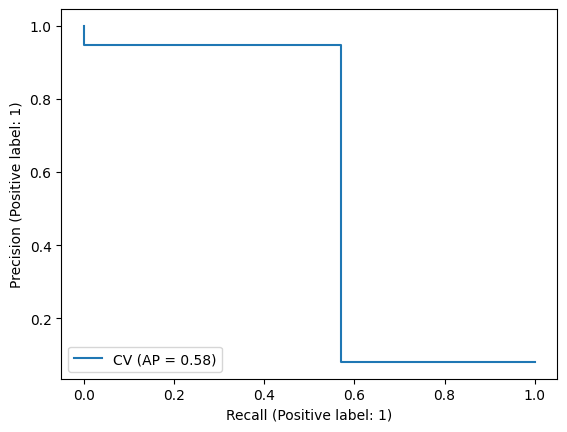

In [15]:
eclf_scores = cross_validate(classifier_pipe, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

with open('.\cv_pr\cv_eclf_scores_full_new_old_gpc_final.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = eclf_scores.keys())
    writer.writeheader()
    writer.writerow(eclf_scores)

start = time.perf_counter()
classifier_pipe.fit(X_train, y_train)
end = time.perf_counter()
train_time = end - start

score = classifier_pipe.score(X_test, y_test.to_numpy()[:, 0])

start = time.perf_counter()
y_pred = classifier_pipe.predict(X_test)
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='Custom Voting Classifier')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name='CV')
plt.savefig('.\cv_new_figs\cv_full_pr.png')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test.to_numpy()[:,0], y_pred, average='binary', pos_label=1)
print('Voting Classifier full new')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)
#full

# Baseline and lower tier hps on full data

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import pandas as pd
from sktime.classification.hybrid import HIVECOTEV2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv

In [4]:
# no downsampling
#depression tweets
from tensorboard.plugins.hparams import api as hp
import uuid
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())*2
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])


#assamble data
data = {}
labels = []
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(1)

for user in st['user_id'].unique():
    tmp = st[st['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(0)

df_data = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
df_labels = pd.DataFrame(labels)
#----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df_data = df_data.transpose()
df_data.index = range(0, len(df_data.index))
df_data.sort_index()
df_data = df_data.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2)

1206


In [30]:
scoring = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc']

C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\gaussian_process\_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Us

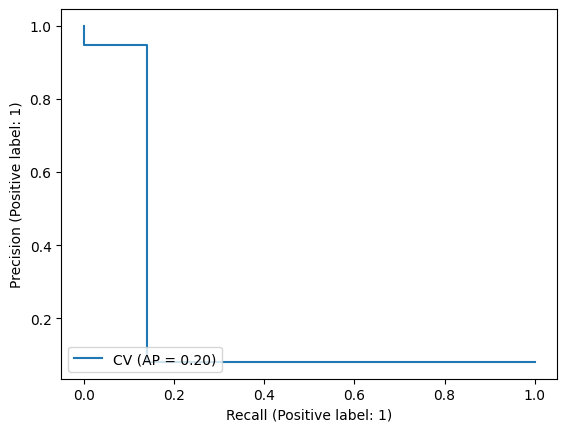

In [16]:
# 1:2 hps on full data
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct

dpk = DotProduct()

clf1 = SVC(C=0.2, gamma='auto', kernel='linear', random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='auto', leaf_size=16, metric='cosine')
clf3 = DecisionTreeClassifier(criterion='gini', splitter='random', random_state=42)
clf4 = GaussianProcessClassifier(kernel=dpk, n_restarts_optimizer=4, max_iter_predict=50, random_state=42)
clf5 = GaussianNB(var_smoothing= 0.0000000001)
clf6 = QuadraticDiscriminantAnalysis(reg_param=0.0000)

eclf = VotingClassifier(
    estimators=[('svm', clf1), ('knn', clf2), ('dtc', clf3), ('gpc', clf4), ('gnb', clf5), ('qda', clf6)],
    voting='hard')

classifier_pipe = make_pipeline(StandardScaler(), eclf)

eclf_scores = cross_validate(classifier_pipe, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

with open('.\cv_pr\cv_eclf_scores_11_on_full_final.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=eclf_scores.keys())
    writer.writeheader()
    writer.writerow(eclf_scores)

start = time.perf_counter()
classifier_pipe.fit(X_train, y_train)
end = time.perf_counter()
train_time = end - start

score = classifier_pipe.score(X_test, y_test.to_numpy()[:, 0])

start = time.perf_counter()
y_pred = classifier_pipe.predict(X_test)
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='Custom Voting Classifier')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name='CV')
plt.savefig('.\cv_new_figs\cv_11_on_full_pr.png')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test.to_numpy()[:, 0], y_pred, average='binary',
                                                           pos_label=1)
print('Voting Classifier 1:2 hps on full data')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)
#1:2 hps on full data

C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\gaussian_process\_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Us

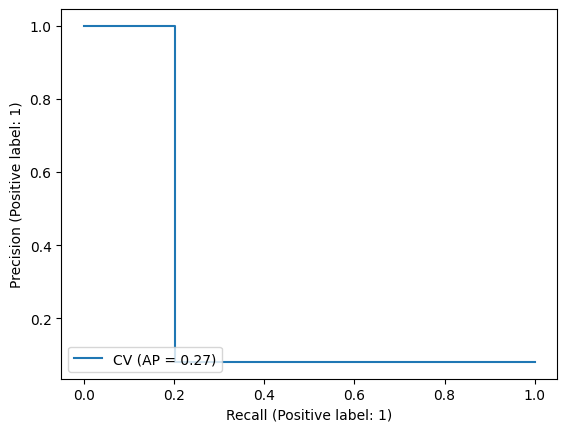

In [17]:
# 1:4 hps on full data
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct

dpk = DotProduct()

clf1 = SVC(C=4.8, gamma='auto', kernel='linear', random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='brute', leaf_size=27, metric='cosine')
clf3 = DecisionTreeClassifier(criterion='log_loss', splitter='best', random_state=42)
clf4 = GaussianProcessClassifier(kernel=dpk, n_restarts_optimizer=4, max_iter_predict=140, random_state=42)
clf5 = GaussianNB(var_smoothing= 0.0000000001)
clf6 = QuadraticDiscriminantAnalysis(reg_param=0.0000)

eclf = VotingClassifier(
    estimators=[('svm', clf1), ('knn', clf2), ('dtc', clf3), ('gpc', clf4), ('gnb', clf5), ('qda', clf6)],
    voting='hard')

classifier_pipe = make_pipeline(StandardScaler(), eclf)
eclf_scores = cross_validate(classifier_pipe, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

with open('.\cv_pr\cv_eclf_scores_double_12_on_full.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=eclf_scores.keys())
    writer.writeheader()
    writer.writerow(eclf_scores)

start = time.perf_counter()
classifier_pipe.fit(X_train, y_train)
end = time.perf_counter()
train_time = end - start

score = classifier_pipe.score(X_test, y_test.to_numpy()[:, 0])

start = time.perf_counter()
y_pred = classifier_pipe.predict(X_test)
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='Custom Voting Classifier')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name='CV')
plt.savefig('.\cv_new_figs\cv_12_on_full_pr.png')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test.to_numpy()[:, 0], y_pred, average='binary',
                                                           pos_label=1)
print('Voting Classifier 1:4 hps on full data')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)
#1:4 hps on full data

C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parame

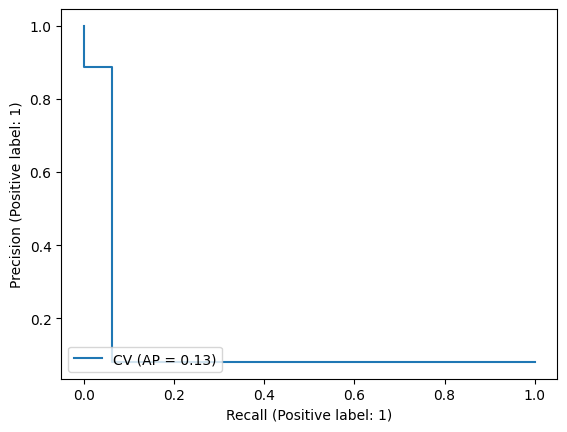

In [18]:
# baseline: no hps on full data
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct

dpk = DotProduct()

clf1 = SVC()
clf2 = KNeighborsClassifier()
clf3 = DecisionTreeClassifier()
clf4 = GaussianProcessClassifier()
clf5 = GaussianNB()
clf6 = QuadraticDiscriminantAnalysis()

eclf = VotingClassifier(
    estimators=[('svm', clf1), ('knn', clf2), ('dtc', clf3), ('gpc', clf4), ('gnb', clf5), ('qda', clf6)],
    voting='hard')

classifier_pipe = make_pipeline(StandardScaler(), eclf)
eclf_scores = cross_validate(classifier_pipe, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)

with open('.\cv_pr\cv_eclf_scores_double_nohps_on_full.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=eclf_scores.keys())
    writer.writeheader()
    writer.writerow(eclf_scores)

start = time.perf_counter()
classifier_pipe.fit(X_train, y_train)
end = time.perf_counter()
train_time = end - start

score = classifier_pipe.score(X_test, y_test.to_numpy()[:, 0])

start = time.perf_counter()
y_pred = classifier_pipe.predict(X_test)
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='Custom Voting Classifier')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name='CV')
plt.savefig('.\cv_new_figs\cv_baseline_pr.png')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test.to_numpy()[:, 0], y_pred, average='binary',
                                                           pos_label=1)
print('Voting Classifier no hps on full data')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)
#baseline: no hps on full data